
"We certify that the code and data in this assignment were generated independently, using only
the tools and resources defined in the course and that we did not receive any external help,
coaching or contributions during the production of this work."


In [15]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.autograd import Variable
import random
from collections import deque

In [16]:
class LinearNN(nn.Module):
    def __init__(self):
        super(LinearNN, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(64, 2)
        self.fc2.weight.data.normal_(0, 0.1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [17]:
env = gym.make("CartPole-v1")

class CartpoleDQNAgent:
    def __init__(self, env, batchSize=50, minBatchSize=50, maxReplayBuffer=1500, epsilon = 1, epsilonDecay=0.999, update=100, gamma=0.9):
        self.env = env
        self.envshape = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape
        self.totalStates = 4
        self.totalAction = env.action_space.n
        self.replay_mem = np.zeros((maxReplayBuffer, self.totalStates * 2 + 2))
        self.model = LinearNN()
        self.target_model = LinearNN()
        self.loss_func = nn.MSELoss()
        self.optimizer = optimizer = optim.Adam(self.model.parameters())
        self.batchSize=batchSize
        self.minBatchSize=minBatchSize
        self.maxReplayBuffer=maxReplayBuffer
        self.epsilon=epsilon
        self.epsilonDecay=epsilonDecay
        self.update=update
        self.target_model.fc1.weight = self.model.fc1.weight
        self.target_model.fc2.weight = self.model.fc2.weight
        self.learn_counter = 0
        self.memory_counter = 0
        self.gamma=gamma

    def step(self, pos):
        pos = torch.unsqueeze(torch.FloatTensor(pos), 0)
        if np.random.uniform() > self.epsilon:   
            actions = self.model.forward(pos)
            action = torch.max(actions, 1)[1].data.numpy()
            action = action[0] if self.envshape == 0 else action.reshape(self.envshape)  
        else: 
            action = np.random.randint(0, self.totalAction)
            action = action if self.envshape == 0 else action.reshape(self.envshape)  
        return action
        
    def buffer(self, state, action, reward, state2):
        tmp = np.hstack((state, [action, reward], state2))
        index = self.memory_counter % self.maxReplayBuffer
        self.replay_mem[index, :] = tmp
        self.memory_counter += 1

    def train(self):
        if len(self.replay_mem) < self.minBatchSize:
            return
        if self.learn_counter % self.update == 0:
            self.target_model.load_state_dict(self.model.state_dict())

        self.learn_counter += 1
        sample_index = np.random.choice(self.maxReplayBuffer, self.batchSize)
        bufferm = self.replay_mem[sample_index, :]
        state = torch.FloatTensor(bufferm[:, :self.totalStates])
        state2 = torch.FloatTensor(bufferm[:, -self.totalStates:])
        reward = torch.FloatTensor(bufferm[:, self.totalStates+1:self.totalStates+2])
        action = torch.LongTensor(bufferm[:, self.totalStates:self.totalStates+1].astype(int))

        q_eval = self.model(state).gather(1, action)  
        q_next = self.target_model(state2).detach()     
        q_target = reward + self.gamma * q_next.max(1)[0].view(self.batchSize, 1)   
        loss = self.loss_func(q_eval, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

agent1 = CartpoleDQNAgent(env)

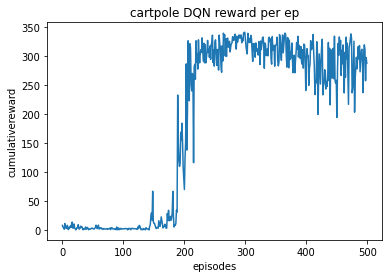

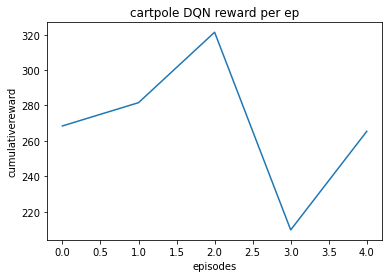

In [18]:
# def cartPoleDQN():
env = gym.make("CartPole-v1")
agent = CartpoleDQNAgent(env)

obs = env.reset()
done = False

# setting up animation
E_DECAY = 0.995

cartDQNplot=[]
cartepsilonplot=[]

n_games = 500
for i_episode in range(n_games):
    state = env.reset()
    reward = 0
    while True:
        action = agent.step(state)
        state2, r, done, info = env.step(action)
        x, x_dot, theta, theta_dot = state2
        r1 = (env.x_threshold - abs(x)) / env.x_threshold - 0.8
        r2 = (env.theta_threshold_radians - abs(theta)) / env.theta_threshold_radians - 0.5
        r = r1 + r2

        agent.buffer(state, action, r, state2)
        reward += r
        if agent.memory_counter > agent.maxReplayBuffer:
            agent.train()

        if done:
            break
        state = state2
        if agent.epsilon > 0.01:
          agent.epsilon *= agent.epsilonDecay
    cartDQNplot.append(reward)

cartDQNgreedy = []
for i_episode in range(5):
    s = env.reset()
    ep_r = 0
    while True:
        a = agent.step(s)
        s_, r, done, info = env.step(a)
        x, x_dot, theta, theta_dot = s_
        r1 = (env.x_threshold - abs(x)) / env.x_threshold - 0.8
        r2 = (env.theta_threshold_radians - abs(theta)) / env.theta_threshold_radians - 0.5
        r = r1 + r2
        ep_r += r

        if done:
            break
        s = s_
        if agent.epsilon > 0.001:
          agent.epsilon *= agent.epsilonDecay
    cartDQNgreedy.append(ep_r)

plt.plot(cartDQNplot)
plt.title('cartpole DQN reward per ep')
plt.xlabel('episodes')
plt.ylabel('cumulativereward')
plt.show()

plt.plot(cartDQNgreedy)
plt.title('cartpole DQN reward per ep')
plt.xlabel('episodes')
plt.ylabel('cumulativereward')
plt.show()

In [19]:
computeUnit = torch.device("cpu")

class Network(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.input_shape = env.observation_space.shape
        self.action_space = action_space

        self.fc1 = nn.Linear(4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 2)

        self.optimizer = optim.Adam(self.parameters(), lr=0.0001)
        self.loss = nn.MSELoss()
        self.to(computeUnit)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

C:\Users\Naman\AppData\Local\Temp\ipykernel_12416\2967741816.py:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.dones = np.zeros(self.memSize, dtype=np.bool)


Episode 1 Average Reward 0.0 Best Reward 16.0 Last Reward 16.0
Episode 3 Average Reward 8.666666666666666 Best Reward 17.0 Last Reward 17.0
Episode 7 Average Reward 11.285714285714286 Best Reward 34.0 Last Reward 34.0
Episode 33 Average Reward 11.363636363636363 Best Reward 85.0 Last Reward 85.0
Episode 41 Average Reward 19.29268292682927 Best Reward 92.0 Last Reward 92.0
Episode 43 Average Reward 21.930232558139537 Best Reward 100.0 Last Reward 100.0
Episode 45 Average Reward 25.2 Best Reward 187.0 Last Reward 187.0
Episode 46 Average Reward 28.717391304347824 Best Reward 349.0 Last Reward 349.0
Episode 47 Average Reward 35.53191489361702 Best Reward 445.0 Last Reward 445.0
Episode 48 Average Reward 44.0625 Best Reward 447.0 Last Reward 447.0
Episode 53 Average Reward 70.90566037735849 Best Reward 572.0 Last Reward 572.0
Episode 59 Average Reward 95.35593220338983 Best Reward 708.0 Last Reward 708.0
Episode 120 Average Reward 256.80833333333334 Best Reward 866.0 Last Reward 866.0
Epis

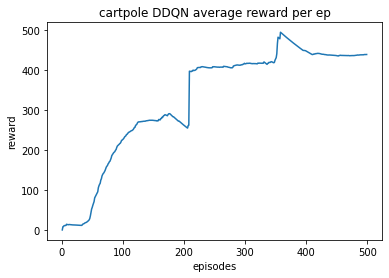

In [20]:
env = gym.make('CartPole-v1').unwrapped
observation_space = env.observation_space.shape[0]
action_space = env.action_space.n

computeUnit = torch.device("cpu")

class ReplayBuffer:
    def __init__(self, size=10000, batchSize=64):
        self.mem_count = 0
        self.memSize=size
        self.batchSize=batchSize
        self.states = np.zeros((self.memSize, *env.observation_space.shape),dtype=np.float32)
        self.states2 = np.zeros((self.memSize, *env.observation_space.shape),dtype=np.float32)
        self.actions = np.zeros(self.memSize, dtype=np.int64)
        self.dones = np.zeros(self.memSize, dtype=np.bool)
        self.rewards = np.zeros(self.memSize, dtype=np.float32)

    
    def add(self, state, action, reward, state2, done):
        idx = self.mem_count % self.memSize
        self.states[idx]  = state
        self.states2[idx] = state2
        self.rewards[idx] = reward
        self.actions[idx] = action
        self.dones[idx] =  1 - done
        self.mem_count += 1
    
    def sample(self):
        maxMem = min(self.mem_count, self.memSize)
        idx = np.random.choice(maxMem, self.batchSize, replace=True)
        states  = self.states[idx]
        actions = self.actions[idx]
        rewards = self.rewards[idx]
        states2 = self.states2[idx]
        dones   = self.dones[idx]
        return states, actions, rewards, states2, dones

class DDQN_Solver:
    def __init__(self):
        self.memory = ReplayBuffer()
        self.epsilon = 1
        self.epsilonDecay=0.99
        self.learn_step_counter = 0
        self.net_copy_interval = 10
        self.model = Network()
        self.model_target = Network()
        self.batchSize=64
        self.gamma=0.95
        self.memory_counter = 0

    def choose_action(self, observation):
        if random.random() < self.epsilon:
            return env.action_space.sample()
        
        state = torch.tensor(observation).float().detach()
        state = state.to(computeUnit)
        state = state.unsqueeze(0)
        q_values = self.model(state)
        return torch.argmax(q_values).item()

    def buffer(self, state, action, reward, state2):
        tmp = np.hstack((state, [action, reward], state2))
        index = self.memory_counter % self.memory.memSize
        self.replay_mem[index, :] = tmp
        self.memory_counter += 1  

    def learn(self):
        if self.memory.mem_count < self.batchSize:
            return
        
        states, actions, rewards, states2, dones = self.memory.sample()

        states = torch.tensor(states , dtype=torch.float32).to(computeUnit)
        states2 = torch.tensor(states2, dtype=torch.float32).to(computeUnit)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(computeUnit)
        actions = torch.tensor(actions, dtype=torch.long).to(computeUnit)
        dones = torch.tensor(dones, dtype=torch.bool).to(computeUnit)

        idx = np.arange(self.batchSize, dtype=np.int64)

        q_values = self.model(states)[idx, actions] 
        next_q_values = self.model_target(states2)
        actions2 = self.model(states2).max(dim=1)[1]
        actions2 = next_q_values[idx, actions2]

        q_target = rewards + self.gamma * actions2 * dones
        td = q_target - q_values

        self.model.optimizer.zero_grad()
        loss = ((td ** 2.0)).mean()
        loss.backward()
        self.model.optimizer.step()

        if self.epsilon>0.001:
            self.epsilon *= self.epsilonDecay

        if self.learn_step_counter % self.net_copy_interval == 0:
            self.model_target.load_state_dict(self.model.state_dict())

        self.learn_step_counter += 1
    
agent = DDQN_Solver()
best_reward = 0
average_reward = 0
episode_number = []
average_reward_number = []
rewardArr = []

for i in range(1, 500):
    state = env.reset()
    state = np.reshape(state, [1, observation_space])
    score = 0

    while True:
        #env.render()
        action = agent.choose_action(state)
        state_, reward, done, info = env.step(action)
        state_ = np.reshape(state_, [1, observation_space])
        agent.memory.add(state, action, reward, state_, done)
        agent.learn()
        state = state_
        score += reward

        if done:
            if score > best_reward:
                best_reward = score
                print("Episode {} Average Reward {} Best Reward {} Last Reward {}".format(i, average_reward/i, best_reward, score))
            average_reward += score 
            break
            
        episode_number.append(i)
        average_reward_number.append(average_reward/i)
        rewardArr.append(score)

plt.plot(episode_number, average_reward_number)
plt.title('cartpole DDQN average reward per ep')
plt.xlabel('episodes')
plt.ylabel('reward')
plt.show()

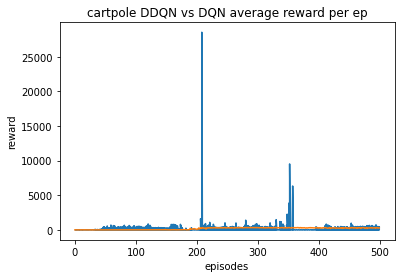

In [21]:
plt.plot(episode_number, rewardArr)
plt.plot(cartDQNplot)
plt.title('cartpole DDQN vs DQN average reward per ep')
plt.xlabel('episodes')
plt.ylabel('reward')
plt.show()